In [31]:
import shap
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import innvestigate
# Innvestigate does not support eager execution
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import innvestigate.utils as iutils
from innvestigate.analyzer.relevance_based.relevance_analyzer import LRPEpsilon

In [4]:
import tensorflow as tf

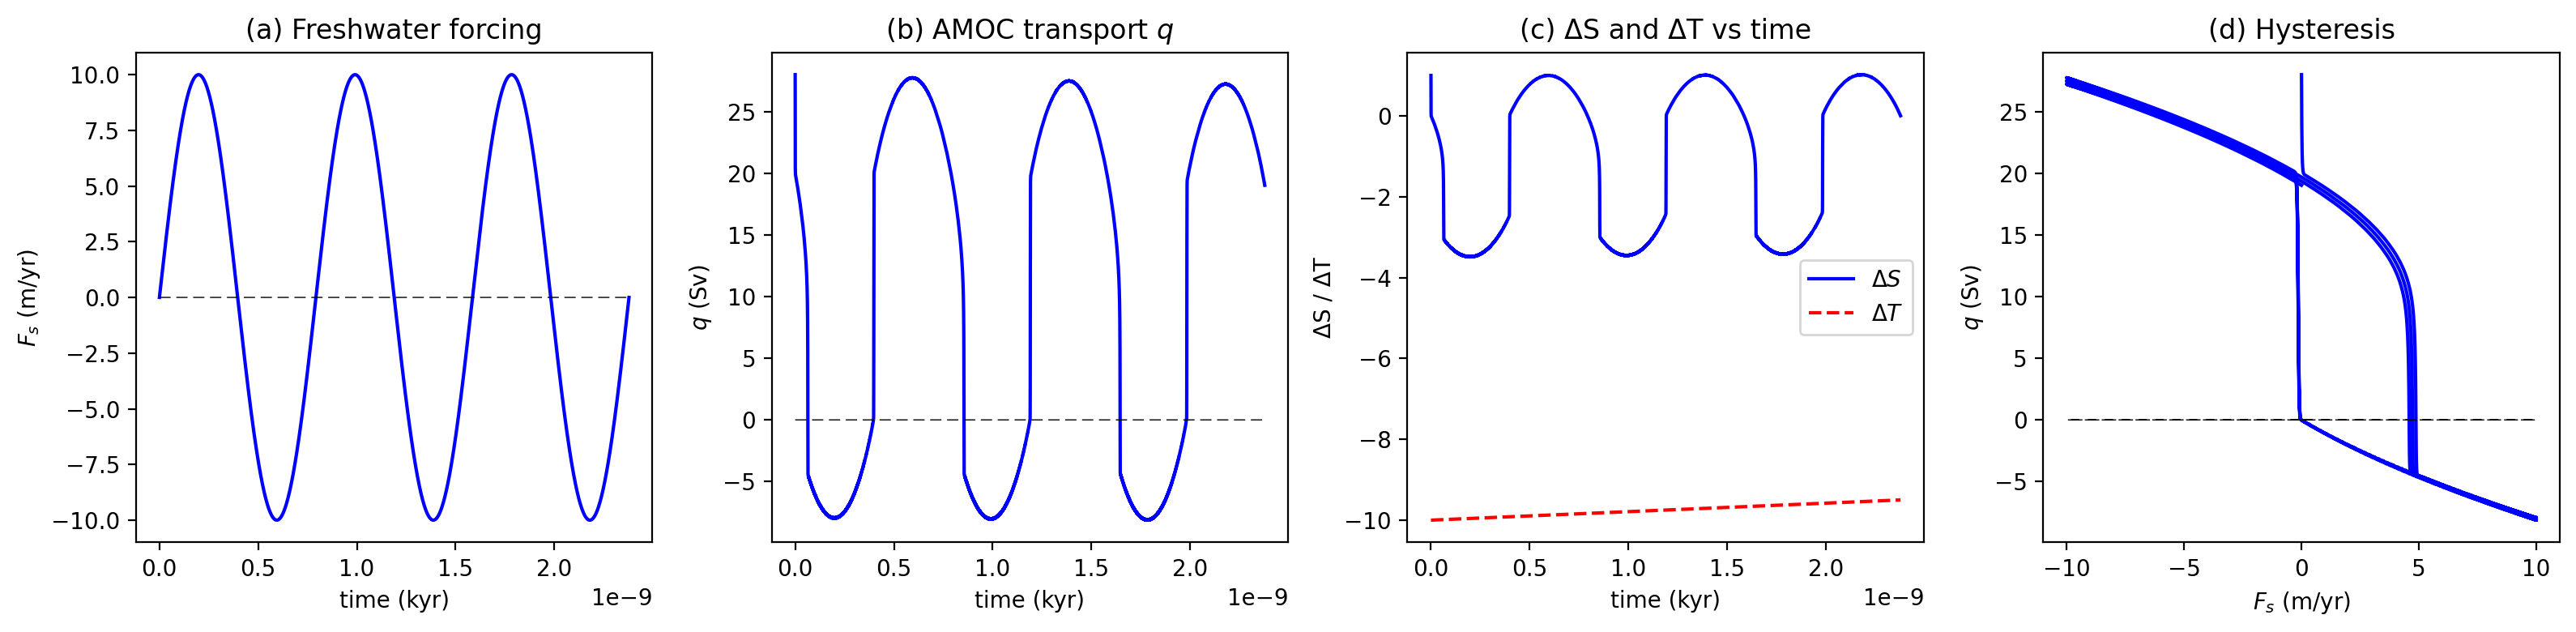

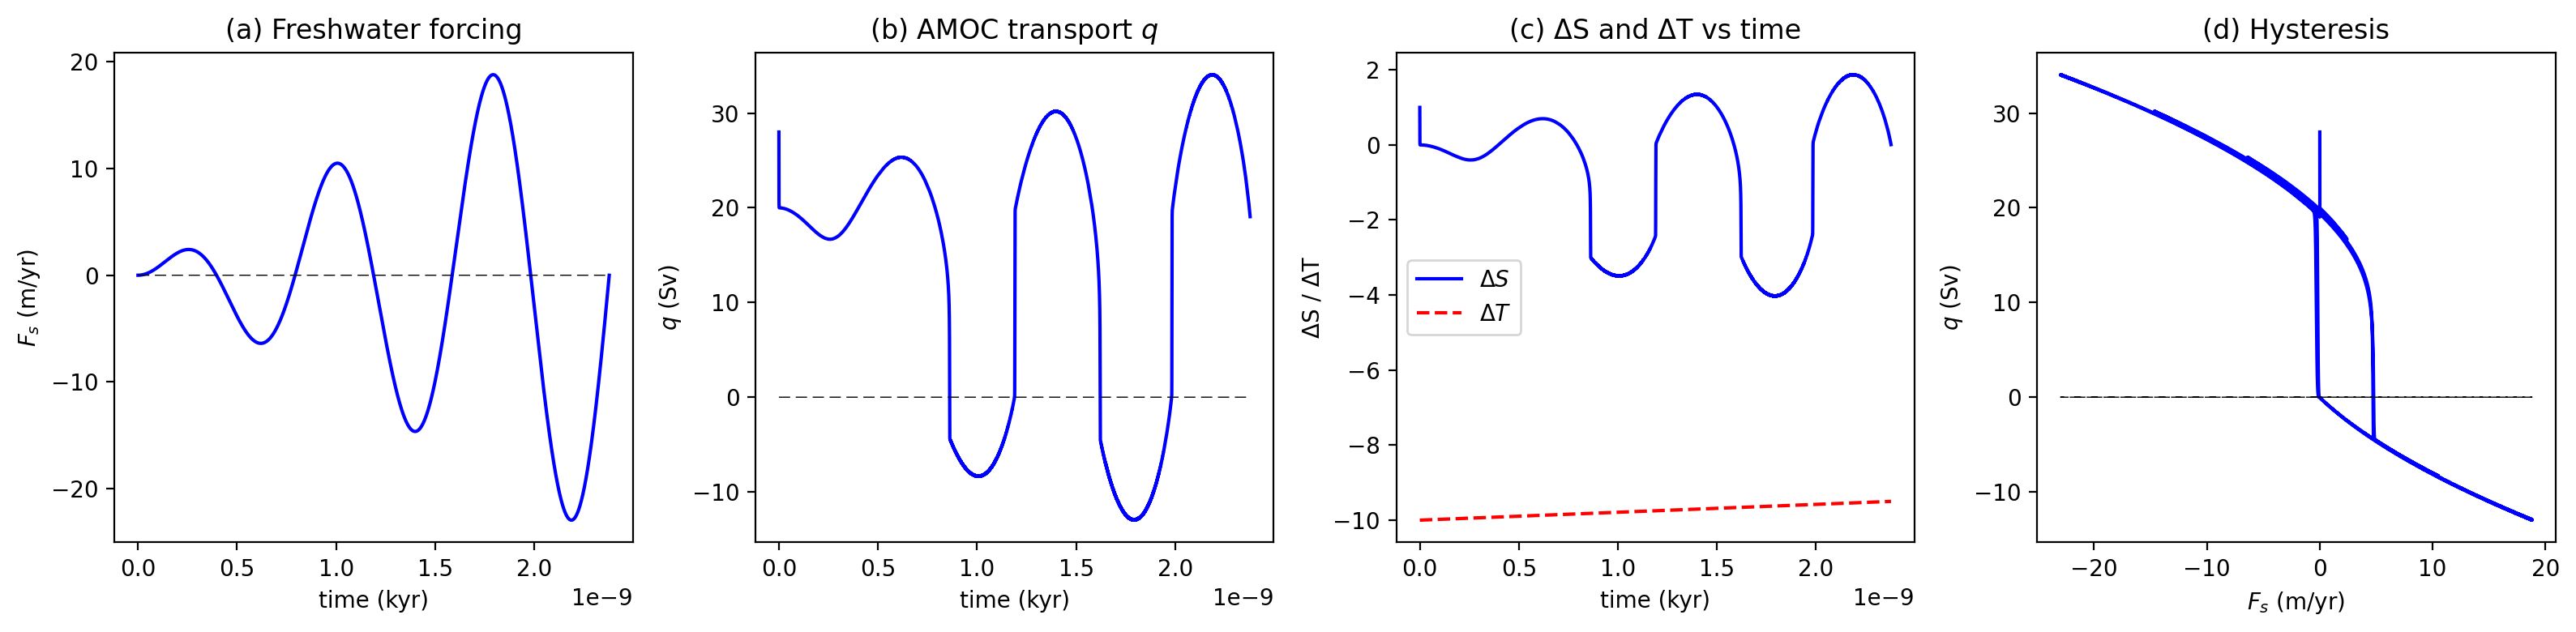

In [5]:
%run 00_generate_data.ipynb

In [6]:
input_data, output_data, qplot = get_data("s")

In [7]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

In [26]:
success, result = simple_innvestigate_test(input_scaled, model_index=0)

=== Simple Innvestigate Test ===
✓ Model loaded successfully
✓ Forward pass works: (5, 1)
✓ Linear activation works: (5, 1)
✓ Analyzer created successfully
✓ LRP calculation works: (5, 4)


In [27]:
is_det, results = test_innvestigate_determinism_safe(input_scaled, model_index=0)

=== Testing Innvestigate Determinism (Graph-Safe) ===
=== Applying Innvestigate Fixes (Graph-Safe) ===
✓ Enabled TensorFlow op determinism
✓ Set single-threaded computation
✓ Set random seeds

Test run 1
  ✓ Run 1 completed successfully

Test run 2
  ✓ Run 2 completed successfully

Test run 3
  ✓ Run 3 completed successfully

=== Determinism Results ===
Run 2 vs Run 1 max difference: 48203.4453125
✗ Run 2 is non-deterministic
Run 3 vs Run 1 max difference: 7940.0400390625
✗ Run 3 is non-deterministic


In [32]:
import innvestigate

model = keras.models.load_model("models/mlp/stationary/ensemble_member_0.keras")

# Force inference mode
model.trainable = False  

# Some analyzers allow explicitly passing training=False
analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
lrp0 = analyzer.analyze(input_scaled)

In [33]:
lrp0

array([[-0.        ,  0.        , -0.        , -0.        ],
       [-0.        ,  0.        , -0.        , -0.        ],
       [-0.        ,  0.        , -0.        , -0.        ],
       ...,
       [ 0.00192203,  0.00049532,  0.00954246,  0.0001199 ],
       [ 0.00192233,  0.00049528,  0.00954392,  0.00011955],
       [ 0.00192263,  0.00049524,  0.0095454 ,  0.00011919]],
      dtype=float32)

In [35]:
lrp1

array([[ 0.35792026,  0.18844758,  0.06165278,  0.01231307],
       [ 0.3628336 ,  0.18063176,  0.06249911,  0.01244367],
       [ 0.36715025,  0.1738185 ,  0.06324267,  0.01255282],
       ...,
       [ 0.45597413, -0.05304305,  0.34121025, -0.00796196],
       [ 0.45595914, -0.0530289 ,  0.34119904, -0.00793704],
       [ 0.45594412, -0.05301475,  0.34118783, -0.00791212]],
      dtype=float32)

In [34]:
import innvestigate

model = keras.models.load_model("models/mlp/stationary/ensemble_member_0.keras")

# Force inference mode
model.trainable = False  

# Some analyzers allow explicitly passing training=False
analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
lrp1 = analyzer.analyze(input_scaled)

In [36]:
analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
lrp1 = analyzer.analyze(input_scaled)
lrp2 = analyzer.analyze(input_scaled)

import numpy as np
print(np.max(np.abs(lrp1 - lrp2)))  # should be 0


0.0


In [8]:
LRP_list = []

for i in range(12):
    tf.keras.backend.clear_session()
    
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # final sigmoid is okay for binary classification
    
    # Load weights in-place (don't overwrite the model)
    model.load_weights(f'models/mlp/stationary/ensemble_member_{i}.keras')
    
    # For LRP, use pre-sigmoid logits, so swap the last activation to linear
    model.layers[-1].activation = tf.keras.activations.linear
    
    LRP_analyzer = LRPEpsilon(model)
    analysisLRP = LRP_analyzer.analyze(input_scaled)
    LRP_list.append(analysisLRP)
    
    print(i)


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


0
1
2
3
4
5
6
7
8
9
10
11


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from innvestigate.analyzer import LRPEpsilon

LRP_list = []

# Optional: set seeds for reproducibility
# import os, random, numpy as np
# os.environ["PYTHONHASHSEED"] = "0"
# os.environ["TF_DETERMINISTIC_OPS"] = "1"
# np.random.seed(123)
# random.seed(123)
# tf.random.set_seed(123)

# Build the model once (structure only)
base_model = Sequential()
base_model.add(Dense(4, input_dim=4, activation='relu'))
base_model.add(Dense(2, activation='relu'))
base_model.add(Dense(1, activation='linear'))  # linear for LRP

for i in range(12):
    tf.keras.backend.clear_session()  # optional if you want to free memory

    # Load the weights into the base model
    model = tf.keras.models.clone_model(base_model)  # clone the structure
    model.load_weights(f'models/mlp/stationary/ensemble_member_{i}.keras')
    model.trainable = False  # ensure inference mode

    # Create analyzer once per model
    LRP_analyzer = LRPEpsilon(model)

    # Analyze input
    analysisLRP = LRP_analyzer.analyze(input_scaled)
    LRP_list.append(analysisLRP)

    print(f"Processed model {i}")


Processed model 0
Processed model 1
Processed model 2
Processed model 3
Processed model 4
Processed model 5
Processed model 6
Processed model 7
Processed model 8
Processed model 9
Processed model 10
Processed model 11


In [46]:
LRP1 = LRP_list

In [48]:
LRP2 = LRP_list

In [49]:
np.array(LRP1) - np.array(LRP2)

array([[[ 6.9701117e-01, -6.2353589e-02, -7.7584374e-01,  1.9631576e-02],
        [ 6.9698757e-01, -5.8956366e-02, -7.7581728e-01,  1.9570485e-02],
        [ 6.9696343e-01, -5.6064203e-02, -7.7579010e-01,  1.9509407e-02],
        ...,
        [ 1.0675291e+00,  2.1654332e-01,  2.0961812e+00, -7.1639973e-03],
        [ 1.0675443e+00,  2.1649577e-01,  2.0962112e+00, -7.1419068e-03],
        [ 1.0675596e+00,  2.1644820e-01,  2.0962410e+00, -7.1198167e-03]],

       [[-2.3607392e-02, -1.7828923e-01,  1.6749315e-03,  2.9408755e-03],
        [-2.3606600e-02, -1.6857493e-01,  1.6748868e-03,  2.9317224e-03],
        [-2.3605805e-02, -1.6030388e-01,  1.6748421e-03,  2.9225685e-03],
        ...,
        [-8.3835840e-02, -2.3269746e-02,  2.0586959e-01, -2.9306714e-03],
        [-8.3837032e-02, -2.3264632e-02,  2.0587251e-01, -2.9216344e-03],
        [-8.3838224e-02, -2.3259522e-02,  2.0587547e-01, -2.9125980e-03]],

       [[ 7.8388885e-02,  2.2347007e-02, -6.8631476e-01, -2.9716380e-02],
        

In [10]:
LRP_list_np.shape

(12, 100000, 4)

In [11]:
LRP_mean = LRP_list_np.mean(axis=0)

In [12]:
LRP_mean.shape

(100000, 4)

In [13]:
LRP_temp = LRP_mean[:, 2]
LRP_sal = LRP_mean[:, 1]

In [14]:
scaler = MinMaxScaler((-1, 1))
scaler.fit(LRP_temp.reshape(-1, 1))
LRP_temp_normalized = scaler.transform(LRP_temp.reshape(-1,1))

In [15]:
scaler = MinMaxScaler((-1, 1))
scaler.fit(LRP_sal.reshape(-1, 1))
LRP_sal_normalized = scaler.transform(LRP_sal.reshape(-1,1))

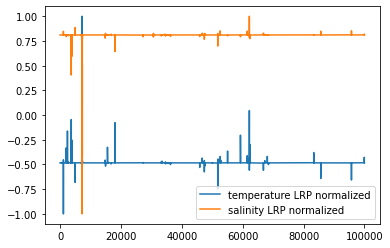

In [16]:
plt.plot(LRP_temp_normalized, label='temperature LRP normalized')
plt.plot(LRP_sal_normalized, label='salinity LRP normalized')
plt.legend()

In [17]:
scaler = MinMaxScaler((-1, 1))
scaler.fit(qplot.reshape(-1, 1))
qplot_normalized = scaler.transform(qplot.reshape(-1,1))

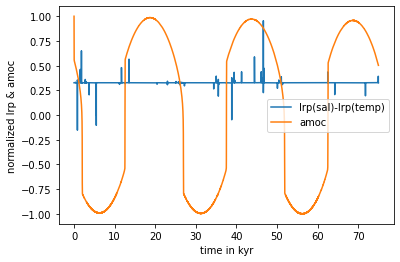

In [18]:
plt.plot(input_data[:, 0], np.abs(LRP_sal_normalized)-np.abs(LRP_temp_normalized), label='lrp(sal)-lrp(temp)')
plt.plot(input_data[:, 0], qplot_normalized, label='amoc')
plt.xlabel('time in kyr')
plt.ylabel('normalized lrp & amoc')
plt.legend()

In [57]:
LRP_temp_normalized[:, 0].shape

(100000,)

=== LRP Temporal Attention Summary ===
Temperature - Mean attention: 0.945
Temperature - High attention periods: 49.0% of time
Salinity - Mean attention: 0.832
Salinity - High attention periods: 50.0% of time

=== Key Attention Periods ===
Temperature-dominant periods:
  Time steps 0 - 14 (duration: 14)
  Time steps 14 - 14 (duration: 0)
  Time steps 14 - 16 (duration: 2)
  Time steps 16 - 24 (duration: 8)
  Time steps 24 - 24 (duration: 0)

Salinity-dominant periods:


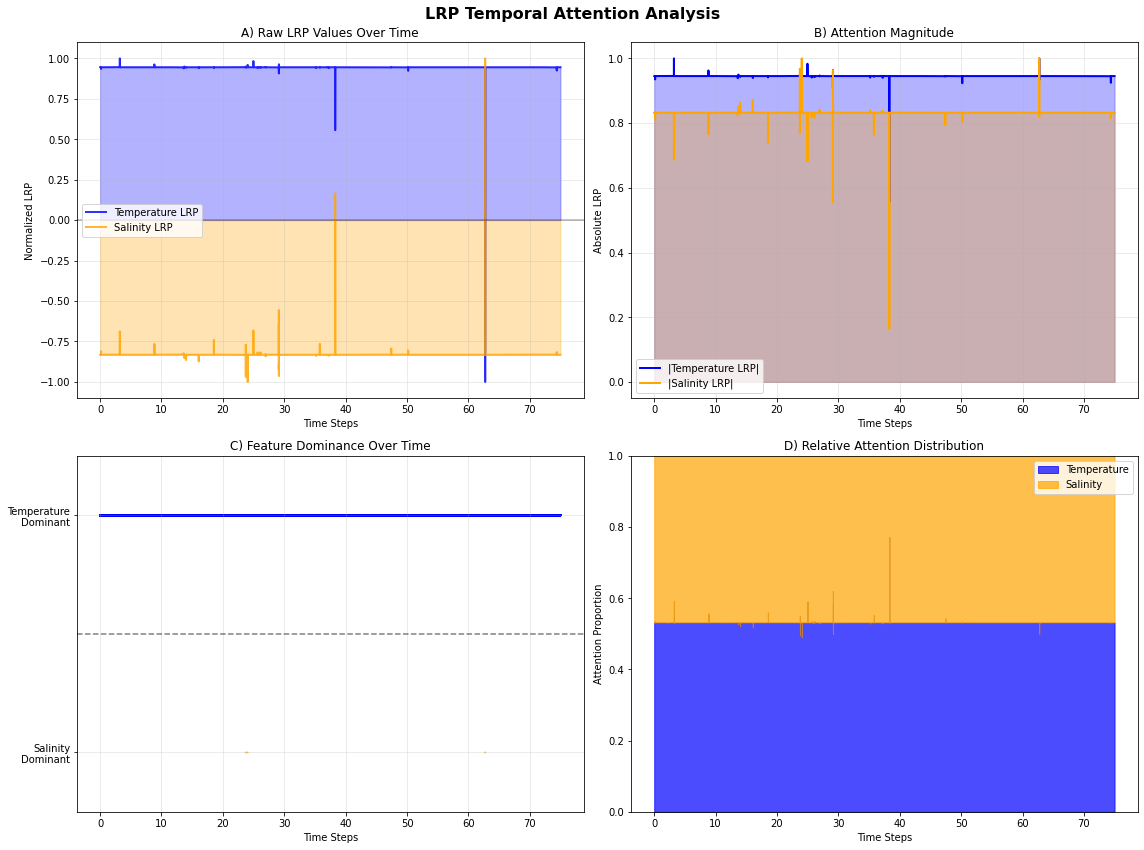

In [60]:
# Replace with your actual data
time_steps = input_data[:, 0]
fig, axes = create_enhanced_lrp_visualization(
    time_steps, 
    LRP_temp_normalized[:, 0], 
    LRP_sal_normalized[:, 0]
)
create_attention_summary(time_steps, LRP_temp_normalized[:, 0], LRP_sal_normalized[:, 0])
plt.show()

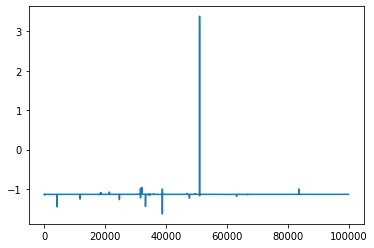

In [52]:
(LRP_temp_normalized/LRP_sal_normalized)

In [26]:
np.where(LRP_temp < -100)

(array([  199, 18146, 21413, 38823, 38829, 38830, 38837, 51058, 51059,
        51060, 66906, 83634, 83635, 83636, 99191, 99192]),)

In [138]:
lrp_temp = LRP_mean[:, 2]/max(LRP_mean[:,2])
lrp_sal = LRP_mean[:, 1]/max(LRP_mean[:,1])

In [148]:
print('min: ' + str(np.min(lrp_sal-lrp_temp)))
print('max: ' + str(np.max(lrp_sal-lrp_temp)))
print('mean: ' + str(np.mean(lrp_sal-lrp_temp)))
print('median: ' + str(np.median(lrp_sal-lrp_temp)))
print('std: ' + str(np.std(lrp_sal-lrp_temp)))

min: -0.990086
max: 1.4182966
mean: -8.729785e-05
median: -5.932566e-05
std: 0.006626531


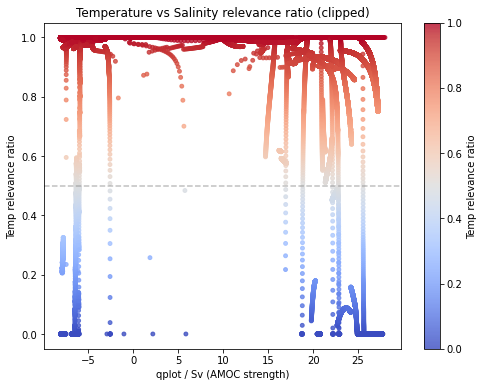

In [169]:
# Compute relevance ratio safely
epsilon = 1e-8
relevance_ratio = lrp_temp / (lrp_temp + lrp_sal)

# Clip to [0, 1]
relevance_ratio = np.clip(relevance_ratio, 0, 1)

# Scatter plot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.figure(figsize=(8,6))
sc = plt.scatter(qplot/Sv, relevance_ratio, c=relevance_ratio, cmap='coolwarm', s=15, alpha=0.8)
plt.colorbar(sc, label="Temp relevance ratio")
plt.axhline(0.5, color='grey', linestyle='--', alpha=0.5)  # equal contribution line
plt.xlabel("qplot / Sv (AMOC strength)")
plt.ylabel("Temp relevance ratio")
plt.title("Temperature vs Salinity relevance ratio (clipped)")

plt.show()


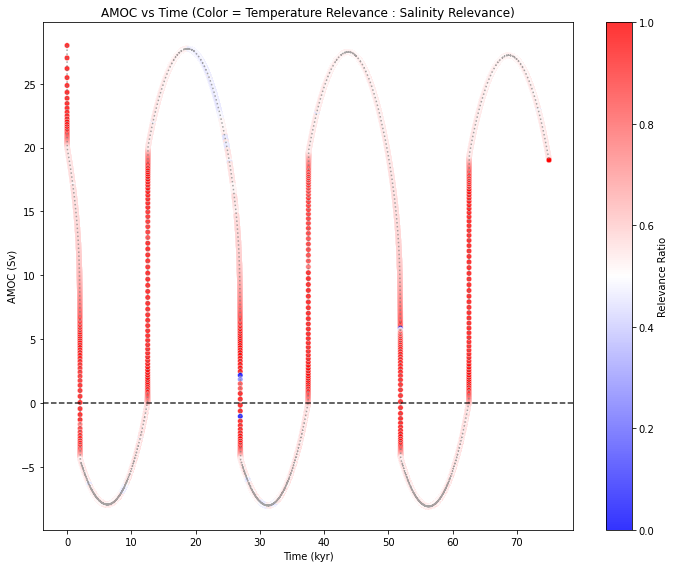

In [170]:
fig, ax = plt.subplots(figsize=(10, 8))

# Background line
ax.plot(input_data[:,0], qplot/Sv, linestyle=':', color='grey', alpha=0.7)

# Color-coded scatter based on salinity - temperature LRP difference
color_values = relevance_ratio
scatter = ax.scatter(input_data[:, 0], qplot/Sv, 
                    c=color_values, 
                    cmap='bwr',  # Red-Blue colormap (red=positive, blue=negative)
                    s=30, 
                    alpha=0.8,
                    edgecolors='white', 
                    linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Relevance Ratio')

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('AMOC vs Time (Color = Temperature Relevance : Salinity Relevance)')
ax.axhline(0, color='black', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

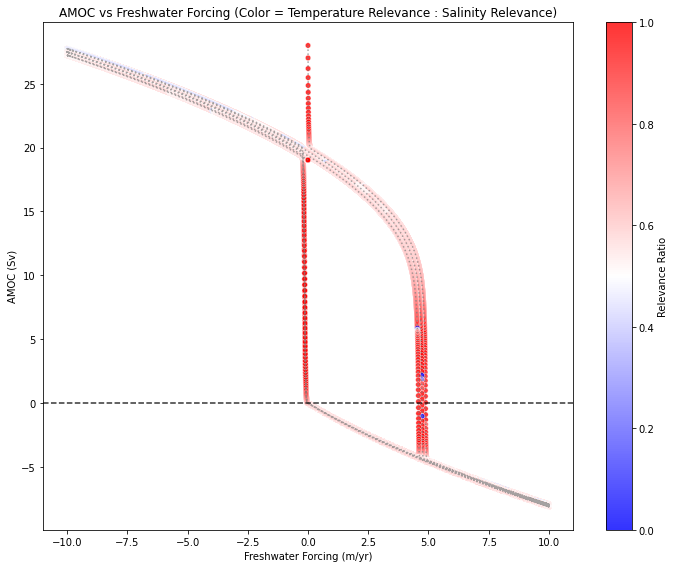

In [164]:
fig, ax = plt.subplots(figsize=(10, 8))

# Background line
ax.plot(input_data[:,3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey', alpha=0.7)

# Color-coded scatter based on salinity - temperature LRP difference
color_values = relevance_ratio
scatter = ax.scatter(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, 
                    c=color_values, 
                    cmap='bwr',  # Red-Blue colormap (red=positive, blue=negative)
                    s=30, 
                    alpha=0.8,
                    edgecolors='white', 
                    linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Relevance Ratio')

ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('AMOC vs Freshwater Forcing (Color = Temperature Relevance : Salinity Relevance)')
ax.axhline(0, color='black', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()